# Frozen Lake

[Reference](https://medium.com/emergent-future/simple-reinforcement-learning-with-tensorflow-part-0-q-learning-with-tables-and-neural-networks-d195264329d0)

In [1]:
import gym
import numpy as np

In [60]:
env = gym.make('FrozenLake-v0')

[2016-12-19 10:26:50,743] Making new env: FrozenLake-v0


In [61]:
# poking at the env
print(env.observation_space)
print(env.observation_space.n)
print(env.observation_space.sample())
print(env.action_space)
print(env.action_space.n)
print(env.action_space.sample())

Discrete(16)
16
7
Discrete(4)
4
3


## Q-Table Learning Algorithm

In [62]:
# we need a table with rows of states and columns of actions : [16x4]
Q = np.zeros([env.observation_space.n, env.action_space.n])

In [63]:
# parameters
lr = 0.85 # learning rate
y = 0.99 # discount factor
num_epi = 2000 # num of episodes of the game

In [65]:
# list of rewards
rlist = []
for i in range(num_epi):
    # get observation --> state
    s = env.reset()
    # sum of rewards in single episode
    rAll = 0
    done = False
    while not done:
    #for j in range(99):
        # pick an action for state 's'
        #  Choose the best action with some noise
        #   the interesting thing about the noise is that it decreases with 'i' (episode count)
        #     as the algorithm runs, the actions become less stochastic with time
        a = np.argmax(Q[s,:] + np.random.randn(1, env.action_space.n)* (1.0/(i+1)))
        # get a new state based on chosen action 'a'
        s1, r, done, _ = env.step(a)
        # we have taken the best action (afwk) and moved to a new state
        #  Update Q-table based on this observation
        Q[s,a] = Q[s,a] + lr * (r + y*np.max(Q[s1,:]) - Q[s,a]) # i do not understand why we need the -Q[s,a] term
        # keep a sum of rewards
        rAll += r
        # update state
        s = s1
    if i%200 == 0:
        print('Game {0}; reward : {1}'.format(i, rAll))
    rlist.append(rAll)

Game 0; reward : 0.0
Game 200; reward : 0.0
Game 400; reward : 1.0
Game 600; reward : 1.0
Game 800; reward : 0.0
Game 1000; reward : 1.0
Game 1200; reward : 1.0
Game 1400; reward : 1.0
Game 1600; reward : 1.0
Game 1800; reward : 1.0


In [71]:
print("Score over time: " +  str(sum(rlist)/num_epi))

Score over time: 0.6985


In [72]:
Q

array([[  2.16348932e-02,   3.66954096e-02,   4.96933434e-01,
          4.01923075e-02],
       [  1.11051839e-02,   1.25086576e-02,   9.36680125e-03,
          3.70455969e-01],
       [  1.32716448e-02,   1.08937260e-02,   2.94399188e-03,
          2.36624308e-01],
       [  2.06632793e-04,   6.19746500e-03,   1.01099854e-03,
          1.58904536e-01],
       [  2.83145833e-01,   9.62075950e-04,   3.97838146e-05,
          9.57423973e-05],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00],
       [  5.40416928e-08,   1.18472746e-04,   3.86485812e-03,
          5.67433630e-04],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00],
       [  7.64775436e-03,   2.90509312e-06,   1.18510834e-03,
          1.82251273e-01],
       [  2.70691183e-03,   6.09400166e-01,   5.05206636e-03,
          1.28170349e-03],
       [  1.10688345e-01,   3.14308638e-04,   7.64293157e-04,
          7.73880470e-07],
       [  0.00000000e

## Frozen Lake with a Neural Network

> *Can we replace the table with a simple neural network*?

In [73]:
import random
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [114]:
env = gym.make('FrozenLake-v0')

[2016-12-19 11:27:08,410] Making new env: FrozenLake-v0


- We will use observation as a vector - input to NN : **[1x16]**
- 1 Layer network
- W : **[16x4]**
- Qout : [1x16 x 16x4] = **[1x4]** (Q value for each action)

In [181]:
tf.reset_default_graph()

In [182]:
x = tf.placeholder(shape=[1,16], dtype=tf.float32)
w = tf.Variable(tf.random_uniform([16,4], 0.0, 0.01))
Qout = tf.matmul(x,w)
predict = tf.argmax(Qout, 1)

In [183]:
# loss
nextQ = tf.placeholder(shape=[1,4], dtype=tf.float32)
loss = tf.reduce_sum(tf.square(Qout - nextQ)) # MSE
# train function
train_fn = tf.train.GradientDescentOptimizer(learning_rate=0.1).minimize(loss)

### Training

In [184]:
# noise
e = 0.1
rlist = []
num_epi = 2000

In [185]:
init = tf.initialize_all_variables()
with tf.Session() as sess:
    sess.run(init)
    for i in range(num_epi):
        s = env.reset()
        rAll = 0
        done = False
        while not done:
            # run predict function
            a, qval = sess.run([predict, Qout], feed_dict={ x : np.identity(16)[s:s+1] }) # because x.shape = [1x16]
            if np.random.rand(1) < e: # noise
                a[0] = env.action_space.sample()
            # get new state and reward from environment
            s1, r, done, _ = env.step(a[0])
            # get Q-value of new state from the network
            Q1 = sess.run(Qout, feed_dict = { x : np.identity(16)[s1:s1+1] })
            # find maximum q-value
            maxQ1 = np.max(Q1)
            targetQ = qval
            targetQ[0, a[0]] = r + y*maxQ1 # y is the **discount** factor
            # train the network using target
            _ = sess.run(train_fn, feed_dict = { x : np.identity(16)[s:s+1], nextQ : targetQ})
            
            # add up rewards
            rAll += r
            # update state
            s = s1
    
        e = 1.0/((i/50) + 10)
        # update e to decrease stochasticity with time
        rlist.append(rAll)            

In [187]:
sum(rlist)/num_epi

0.3745

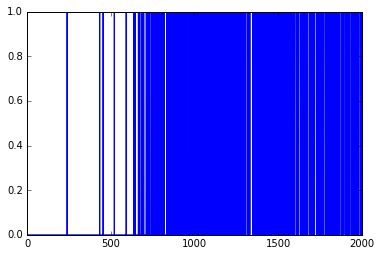

In [186]:
plt.plot(rlist)